# Metrics Study

This notebook will focus on studying the results obtained from the tests done with both QA and QAOA.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from Bio import Phylo
import re
from io import StringIO
import os

---
# QA

## RF distance

In [15]:
# Load the data

rf = pd.read_csv('metrics/RF-distance.csv')

rf.head()

grouped_df = rf.groupby("size", as_index=False)["RF"].mean()

# Renombrar la columna de RF para mayor claridad
grouped_df.rename(columns={"RF": "Media RF"}, inplace=True)


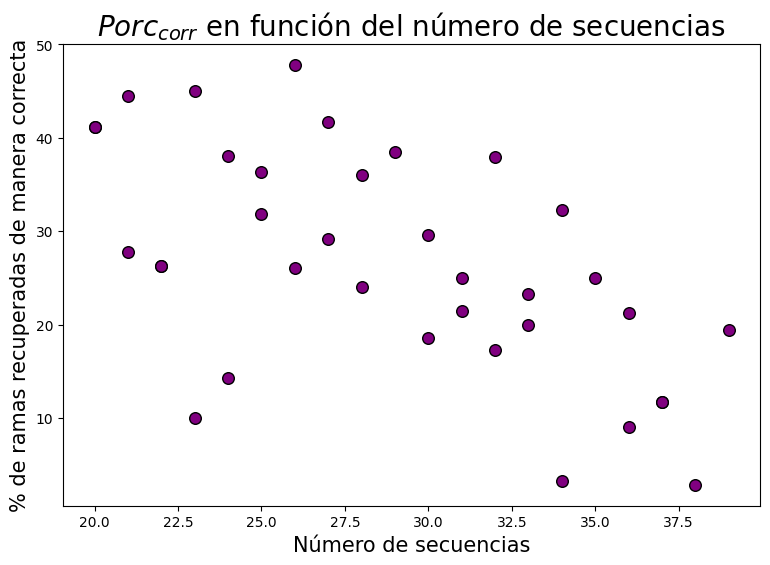

In [12]:
# Plot the data
plt.subplots(figsize=(9, 6))
plt.scatter(rf['size'], rf['RF'], edgecolor='k', color='purple', s=70)
# plt.plot(grouped_df['size'], grouped_df['Media RF'], color='red', lw=2)
plt.xlabel('Número de secuencias',fontdict={'fontsize': 15})
plt.ylabel('% de ramas recuperadas de manera correcta',fontdict={'fontsize': 15})
plt.title('$Porc_{corr}$ en función del número de secuencias', fontsize=20)
plt.show()

In [13]:
# Create a linear regression model and plot it with the cloud of points

from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(rf[['size']], rf['RF'])

fig,ax = plt.subplots(figsize=(10,8))

ax.plot(rf['size'], rf['RF'], 'o')

y_pred = model.predict(rf[['size']])

ax.plot(rf['size'], y_pred)

plt.show()

ModuleNotFoundError: No module named 'sklearn'

Then we can try to explain the outliers by using different tree parameters like average branch length or length of sequence. But first, let's identify outliers.

In [14]:
residuals = rf['RF'] - y_pred

# Identify outliers (using z-scores)
threshold = 1.75  # Customize the z-score threshold
outlier_mask = np.abs(zscore(residuals)) > threshold

# Plot the data points and outliers
plt.figure(figsize=(10, 6))
plt.scatter(rf['size'], rf['RF'], label='Datos', color='blue')
plt.scatter(rf['size'][outlier_mask], rf['RF'][outlier_mask], label='Atípicos', color='red', edgecolor='k', s=100)
plt.plot(rf['size'], y_pred, label='Recta de regresión', color='green', linewidth=2)
plt.xlabel('Número de secuencias',fontdict={'fontsize': 15})
plt.ylabel('% de ramas recuperadas de manera correcta',fontdict={'fontsize': 15})
plt.title('$Porc_{corr}$ en función del número de secuencias', fontsize=20)
plt.legend()
plt.show()

NameError: name 'y_pred' is not defined

In [15]:
print(rf['id'][outlier_mask].values)

NameError: name 'outlier_mask' is not defined

In [16]:
# Median of all rf
median_rf = rf['RF'].median()
print(f'Median of all RF: {median_rf}')

# Mean of all rf
mean_rf = rf['RF'].mean()
print(f'Mean of all RF: {mean_rf}')

Median of all RF: 26.205
Mean of all RF: 26.547222222222224


## Time

In [62]:
time = pd.read_csv('metrics/timer.csv')
# time_table = time.groupby('size')['time'].mean().reset_index()
# time_table['time'] = time_table['time']/1000
# time_table['Media RF'] = grouped_df['Media RF'].values

# print(time_table.to_latex(index=False,
#     float_format="%.2f",
#     caption="Métricas medias por tamaño",
#     label="tab:metricas_qa"))

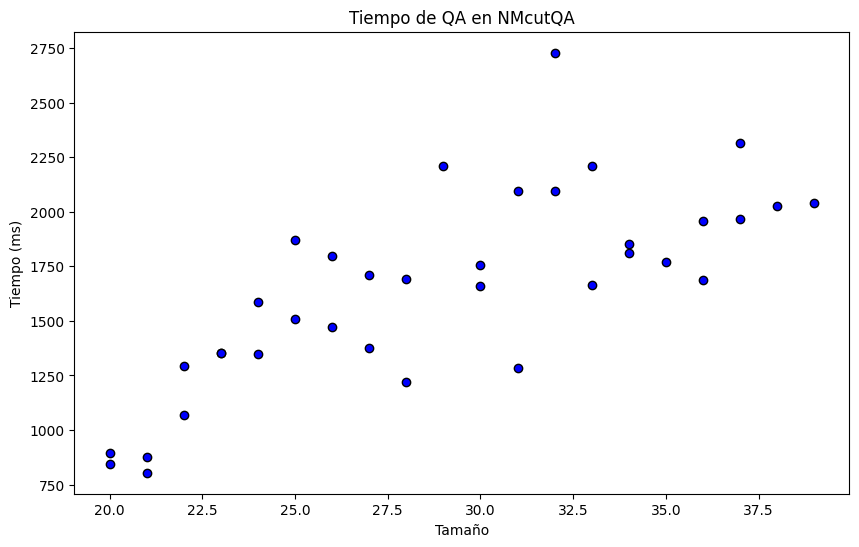

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(time['size'], time['time'], color='blue', edgecolor='k')
plt.xlabel('Tamaño')
plt.ylabel('Tiempo (ms)')
plt.title('Tiempo de QA en NMcutQA')
plt.show()

In [30]:
mean_rf = time['time'].mean()
print(f'Mean of all RF: {mean_rf}')

Mean of all RF: 1645.0278622222224


In [19]:
# Seems linear so, linear regression it is

model = LinearRegression()

model.fit(time[['size']], time['time'])

fig,ax = plt.subplots(figsize=(10,8))

X = time['size']
y = time['time']

ax.plot(X, y, 'o')

y_pred = model.predict(rf[['size']])

ax.plot(X, y_pred)

plt.show()

NameError: name 'LinearRegression' is not defined

Text(0.5, 1.0, 'Approximate number of subproblems in NMcutQA')

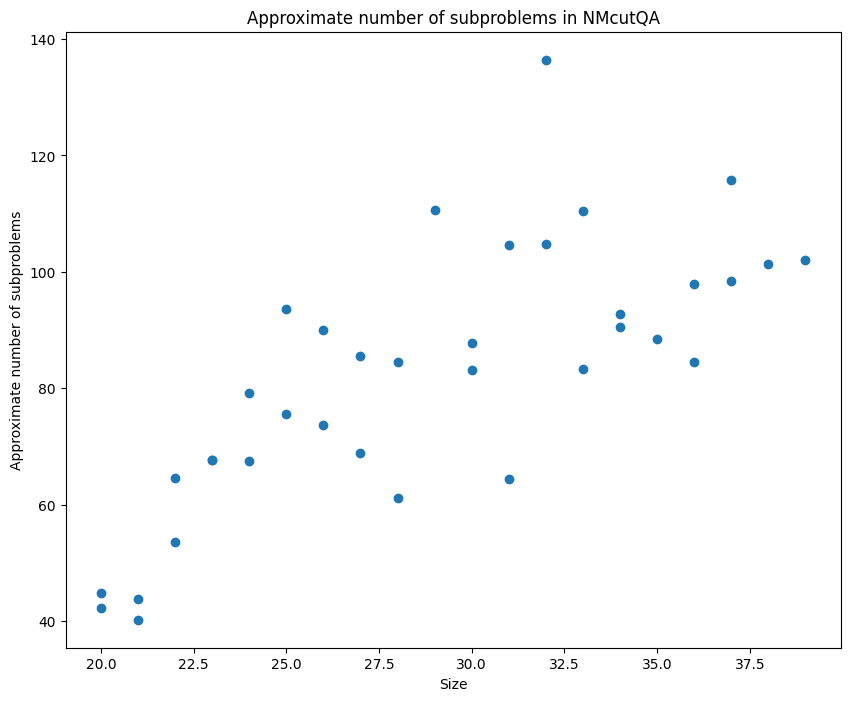

In [20]:
transform_time = time['time']/20

plt.subplots(figsize=(10,8))

plt.plot(time['size'], transform_time, 'o')
plt.xlabel('Size')
plt.ylabel('Approximate number of subproblems')

plt.title('Approximate number of subproblems in NMcutQA')

---
# QAOA

The QAOA, as espected, performed a lot worse than the QA, both in time and RF, let's see the few executions it made

## Time

In [21]:
qaoa_time = pd.read_csv('metrics/timer_qaoa.csv',dtype={'size':int,'time':float})
qaoa_time.head()

,size,name,time
0,20,matrix_10618.npy,1.885833e+07
1,20,matrix_41388.npy,1.871889e+07
2,21,matrix_45255.npy,2.240694e+07
3,21,matrix_48947.npy,2.013079e+07
4,10,matrix_28864.npy,9.110392e+04


In [31]:
mean_rf = qaoa_time['time'].mean()
print(f'Mean of all RF: {mean_rf}')

Mean of all RF: 3162470.433773265


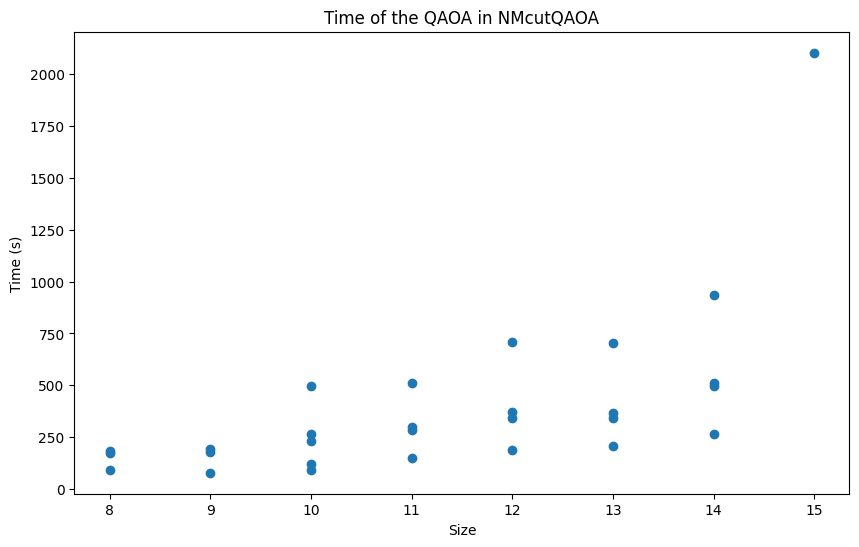

In [22]:
plt.figure(figsize=(10, 6))
filtered_time = qaoa_time[qaoa_time['time'] < 5000000]
plt.plot(filtered_time['size'], (filtered_time['time']/1000), 'o')
plt.xlabel('Size')
plt.ylabel('Time (s)')
plt.title('Time of the QAOA in NMcutQAOA')
plt.show()

In [23]:
hours = qaoa_time['time'].sum()/1000/3600
print(f'\033[1mThe whole ordeal (4 trees) took {hours} hours to execute\033[22m')

The whole ordeal (4 trees) took 29.867776318969728 hours to execute


In [24]:
# Seems linear so, linear regression it is

model = LinearRegression()

model.fit(qaoa_time[['size']], qaoa_time['time'])

fig,ax = plt.subplots(figsize=(10,8))

X = qaoa_time['size']
y = qaoa_time['time']

ax.plot(X, y, 'o')

y_pred = model.predict(qaoa_time[['size']])

ax.plot(X, y_pred)

plt.show()

NameError: name 'LinearRegression' is not defined

It's stupid to do statistics when having 2 or 3 values, so we can try to use smaller trees. Also:

## RF

In [6]:
rf_qaoa = pd.read_csv('metrics/RF-distance_qaoa.csv')
rf_qaoa.head()

# grouped_df = rf_qaoa.groupby("size", as_index=False)["RF"].mean()
# grouped_time = qaoa_time.groupby("size", as_index=False)["time"].mean()
# grouped_df.insert(1, 'Tiempo (min)', (grouped_time['time'].values/1000)/60)
# # Renombrar la columna de RF para mayor claridad
# grouped_df.rename(columns={"RF": "Media RF",'size':'Tamaño'}, inplace=True)

# print(grouped_df.to_latex(index=False,
#     float_format="%.2f",
#     caption="Media de RF por tamaño",
#     label="tab:metricas_qaoa"))

,size,id,RF
0,10,28864,0.0
1,11,11523,12.5
2,12,7791,0.0
3,13,13951,0.0
4,14,10953,0.0


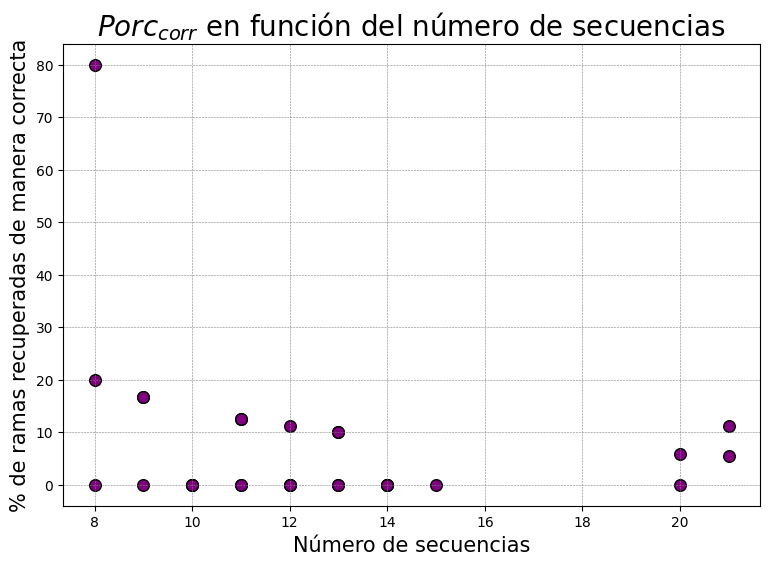

In [7]:
# Plot the data
plt.subplots(figsize=(9, 6))
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.scatter(rf_qaoa['size'], rf_qaoa['RF'], edgecolor='k', color='purple', s=70)
# plt.plot(grouped_df['size'], grouped_df['Media RF'], color='red', lw=2)
plt.xlabel('Número de secuencias',fontdict={'fontsize': 15})
plt.ylabel('% de ramas recuperadas de manera correcta',fontdict={'fontsize': 15})
plt.title('$Porc_{corr}$ en función del número de secuencias', fontsize=20)

plt.show()

In [32]:
mean_rf = rf_qaoa['RF'].mean()
print(f'Mean of all RF: {mean_rf}')

Mean of all RF: 6.838709677419355


---
# Comparisons

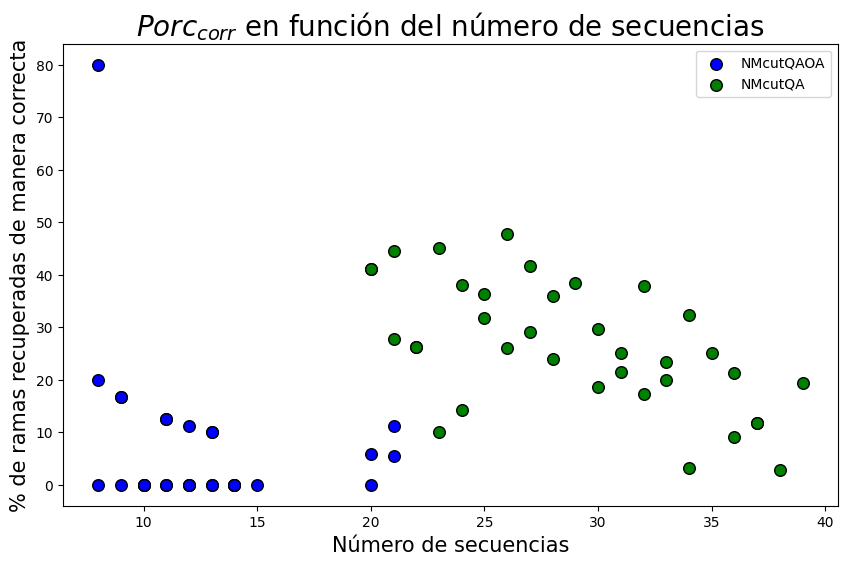

In [27]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(rf_qaoa['size'], rf_qaoa['RF'], edgecolor='k', color='blue', s=70,label='NMcutQAOA')
plt.scatter(rf['size'], rf['RF'], edgecolor='k', color='green', s=70,label='NMcutQA')
plt.legend()
plt.xlabel('Número de secuencias',fontdict={'fontsize': 15})
plt.ylabel('% de ramas recuperadas de manera correcta',fontdict={'fontsize': 15})
plt.title('$Porc_{corr}$ en función del número de secuencias', fontsize=20)
plt.show()

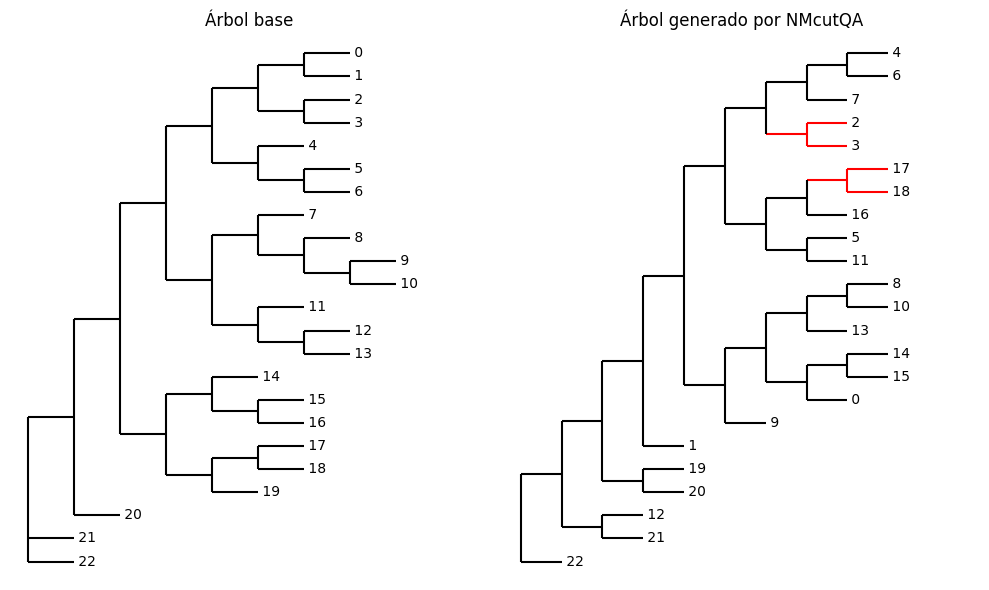

In [28]:
id = 48363
# get size from rf where id=id

size = rf[rf['id'] == str(id)]['size'].values[0]

with open(f'trees/{size}/qa_tree_{id}.newick','r') as file:
    qa_tree = file.read()
    
with open(f'trees/{size}/tree_best_{id}.newick','r') as file:
    biotree = file.read()
    
biotree = re.sub(r'taxon([0-9]+)',lambda match: str(int(match.group(1)) - 1),biotree)
biotree = re.sub(r':[0-9]\.[0-9]+(e-[0-9]+)*',r'',biotree)
# print(biotree)

tree1 = Phylo.read(StringIO(qa_tree), "newick")
# Phylo.draw(tree1)
tree2 = Phylo.read(StringIO(biotree), "newick")
# Phylo.draw(tree2)


# Function to get clade terminal taxa sets by name
def get_clade_taxa_sets(tree):
    return {
        frozenset(term.name for term in clade.get_terminals()) 
        for clade in tree.find_clades() if len(clade.get_terminals()) > 1 and len(clade.get_terminals()) != size  # Only internal clades
    }

# Find common clades based on their terminal taxa
common_taxa_sets = get_clade_taxa_sets(tree1).intersection(get_clade_taxa_sets(tree2))

# Function to color branches with common taxa in red
def color_common_branches(tree, common_taxa_sets):
    for clade in tree.find_clades():
        # Only consider internal clades (with more than one terminal)
        if len(clade.get_terminals()) > 1:
            # Check if the clade's terminals match a common set
            if frozenset(term.name for term in clade.get_terminals()) in common_taxa_sets:
                clade.color = "red"
            else:
                clade.color = "black"  # Default color for non-common branches

# Color the branches in the first tree
color_common_branches(tree1, common_taxa_sets)
# color_common_branches(tree2, common_taxa_sets)

# Create a figure with subplots (side by side)
fig, (axes1, axes2) = plt.subplots(1, 2, figsize=(10, 6))

# Plot the second tree
Phylo.draw(tree2, do_show=False, axes=axes1)
axes1.set_title("Árbol base")
plt.setp(axes1, xticks=[], yticks=[])  # Remove ticks
axes1.axis('off')  # Remove axes

# Plot the first tree
Phylo.draw(tree1, do_show=False, axes=axes2)
axes2.set_title("Árbol generado por NMcutQA")
plt.setp(axes2, xticks=[], yticks=[])  # Remove ticks
axes2.axis('off')  # Remove axes

# Show the plot
plt.tight_layout()
plt.show()

---
## Comparation

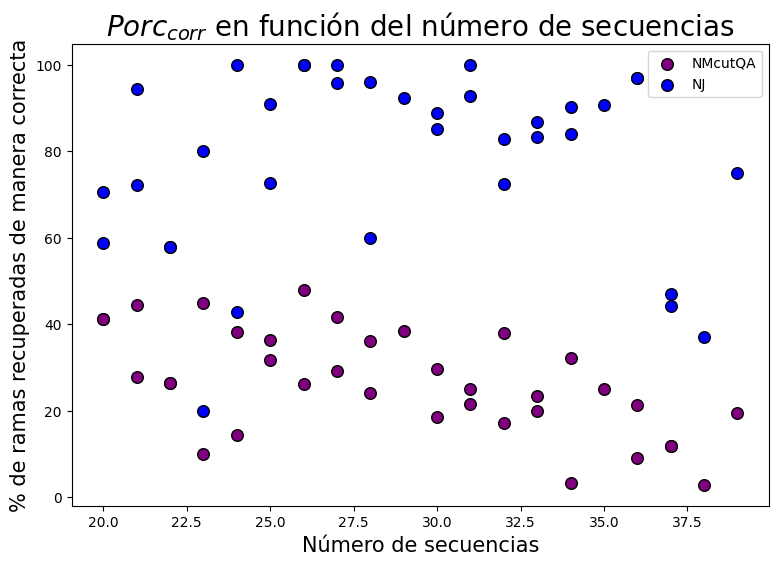

In [67]:
rf_nf = pd.read_csv('metrics/RF-nj.csv')

plt.subplots(figsize=(9, 6))
plt.scatter(rf['size'], rf['RF'], edgecolor='k', color='purple', s=70)
plt.scatter(rf_nf['size'], rf_nf['RF'], edgecolor='k', color='blue', s=70)
# plt.plot(grouped_df['size'], grouped_df['Media RF'], color='red', lw=2)
plt.xlabel('Número de secuencias',fontdict={'fontsize': 15})
plt.ylabel('% de ramas recuperadas de manera correcta',fontdict={'fontsize': 15})
plt.title('$Porc_{corr}$ en función del número de secuencias', fontsize=20)
plt.legend(['NMcutQA','NJ'])
plt.show()

In [33]:
mean_rf = rf_nf['RF'].mean()
print(f'Mean of all RF: {mean_rf}')

Mean of all RF: 78.24083333333333


## Theoretical best

In [3]:
rf_bf = pd.read_csv('metrics/RF-distance_bf.csv')

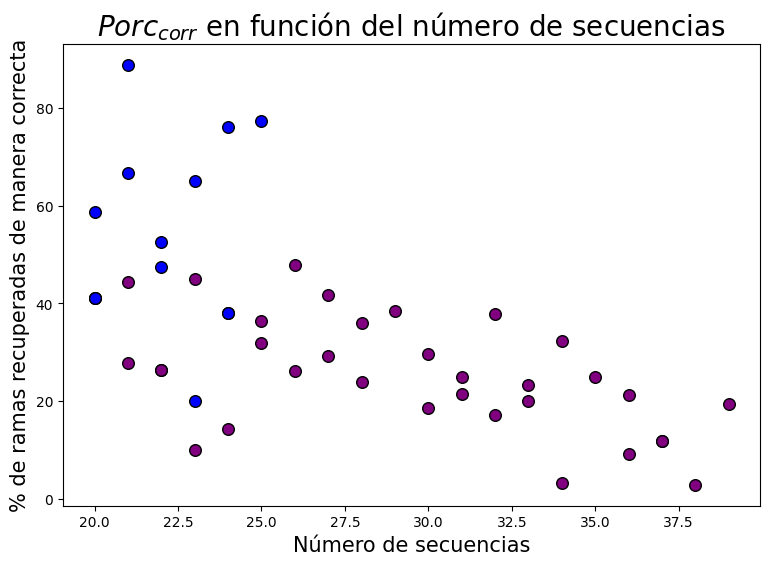

In [4]:
# Plot the data
plt.subplots(figsize=(9, 6))
plt.scatter(rf['size'], rf['RF'], edgecolor='k', color='purple', s=70)
plt.scatter(rf_bf['size'], rf_bf['RF'], edgecolor='k', color='blue', s=70)
# plt.plot(grouped_df['size'], grouped_df['Media RF'], color='red', lw=2)
plt.xlabel('Número de secuencias',fontdict={'fontsize': 15})
plt.ylabel('% de ramas recuperadas de manera correcta',fontdict={'fontsize': 15})
plt.title('$Porc_{corr}$ en función del número de secuencias', fontsize=20)
plt.show()

In [7]:
mean_rf = rf_bf['RF'].mean()
print(f'Mean of all RF: {mean_rf}')
print(f'Percentage: {26.547222222222/mean_rf*100}%')

Mean of all RF: 57.46545454545455
Percentage: 46.19683674689015%


# Qiskit QAOA

## RF distance

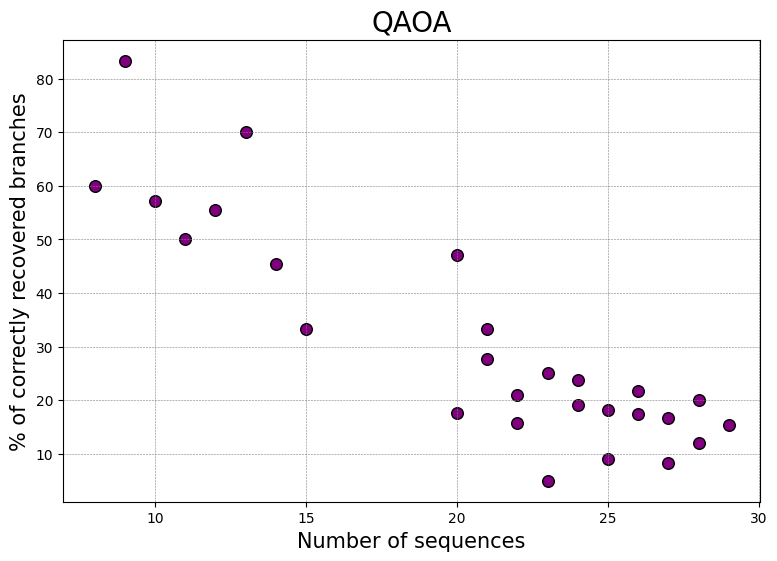

In [75]:
qiskit_df = pd.read_csv('metrics/RF-distance_qiskit.csv')

# Plot the data
plt.subplots(figsize=(9, 6))
plt.scatter(qiskit_df['size'], qiskit_df['RF'], edgecolor='k', color='purple', s=70)
plt.xlabel('Number of sequences',fontdict={'fontsize': 15})
plt.ylabel('% of correctly recovered branches',fontdict={'fontsize': 15})
plt.title('QAOA', fontsize=20)
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.show()

Let's compare the results using qiskit QAOA with the results obtained using our QAOA. However, we still get the same downward pattern that we get with the QA.

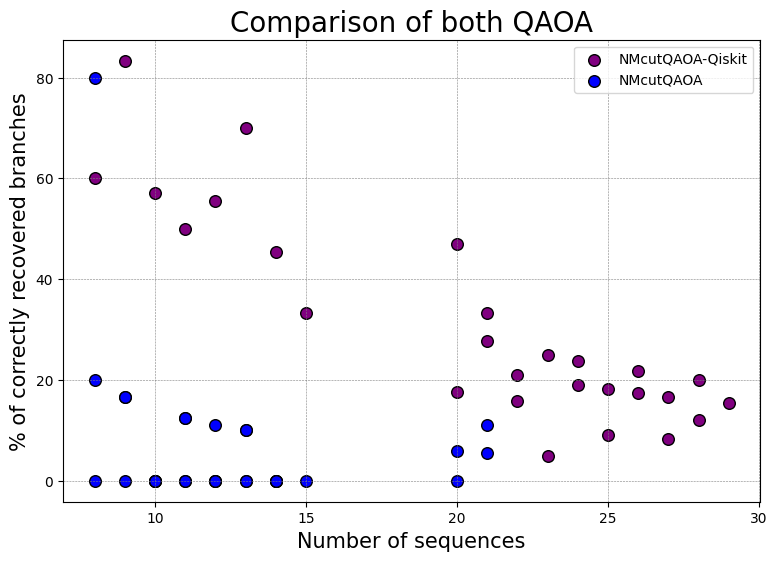

In [14]:
# Plot the data
plt.subplots(figsize=(9, 6))
plt.scatter(qiskit_df['size'], qiskit_df['RF'], edgecolor='k', color='purple', s=70,label='NMcutQAOA-Qiskit')
plt.scatter(rf_qaoa['size'], rf_qaoa['RF'], edgecolor='k', color='blue', s=70,label='NMcutQAOA')
# plt.plot(grouped_df['size'], grouped_df['Media RF'], color='red', lw=2)
plt.xlabel('Number of sequences',fontdict={'fontsize': 15})
plt.ylabel('% of correctly recovered branches',fontdict={'fontsize': 15})
plt.title('Comparison of both QAOA', fontsize=20)
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.legend()
plt.show()

The results are really good, they all get better results than our own QAOA, so let's then compare it to the QA method.

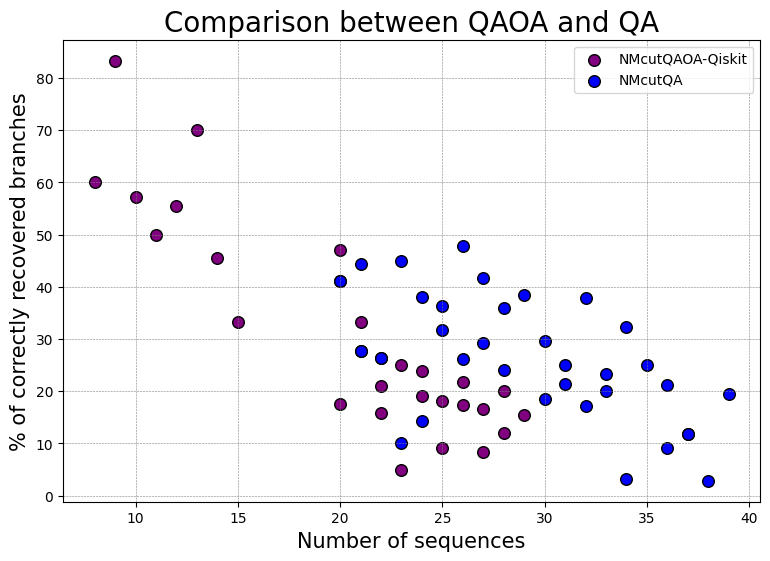

In [21]:
# Plot the data
plt.subplots(figsize=(9, 6))
plt.scatter(qiskit_df['size'], qiskit_df['RF'], edgecolor='k', color='purple', s=70,label='NMcutQAOA-Qiskit')
plt.scatter(rf['size'], rf['RF'], edgecolor='k', color='blue', s=70,label='NMcutQA')

# plt.plot(grouped_df['size'], grouped_df['Media RF'], color='red', lw=2)
plt.xlabel('Number of sequences',fontdict={'fontsize': 15})
plt.ylabel('% of correctly recovered branches',fontdict={'fontsize': 15})
plt.title('Comparison between QAOA and QA', fontsize=20)
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.legend()
plt.show()

Full diagram

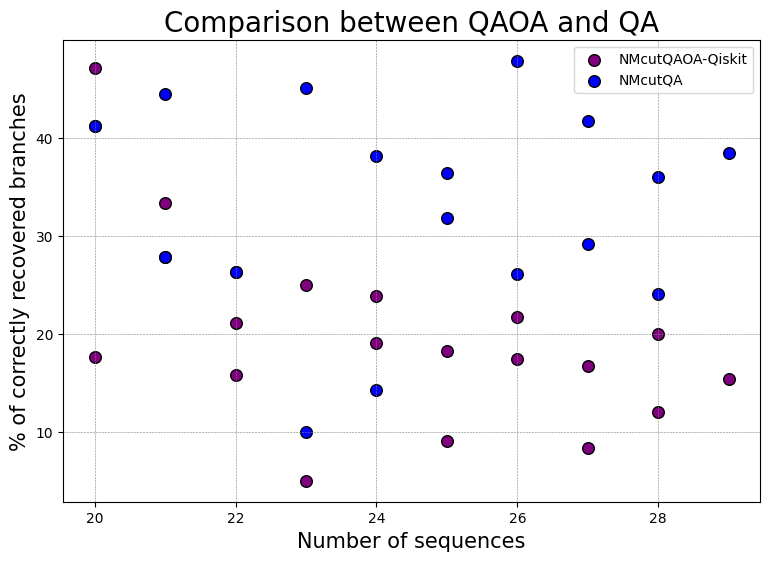

In [22]:
# Plot the data
plt.subplots(figsize=(9, 6))
plt.scatter(qiskit_df[qiskit_df['size']>15]['size'], qiskit_df[qiskit_df['size']>15]['RF'], edgecolor='k', color='purple', s=70,label='NMcutQAOA-Qiskit')
plt.scatter(rf[rf['size']<30]['size'], rf[rf['size']<30]['RF'], edgecolor='k', color='blue', s=70,label='NMcutQA')

# plt.plot(grouped_df['size'], grouped_df['Media RF'], color='red', lw=2)
plt.xlabel('Number of sequences',fontdict={'fontsize': 15})
plt.ylabel('% of correctly recovered branches',fontdict={'fontsize': 15})
plt.title('Comparison between QAOA and QA', fontsize=20)
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.legend()
plt.show()

As expected we get worst results than with QA but still really good results for QAOA method. However the time is a different story.

## Time


In [25]:
qiskit_time = pd.read_csv('metrics/timer_qaoa_qiskit.csv', dtype={'size':int,'time':float})
qiskit_time.head()

,size,name,time
0,8,matrix_1822.npy,1867.223145
1,9,matrix_32709.npy,3135.470947
2,10,matrix_28864.npy,4566.642334
3,11,matrix_11523.npy,5367.900879
4,12,matrix_7791.npy,8472.245361


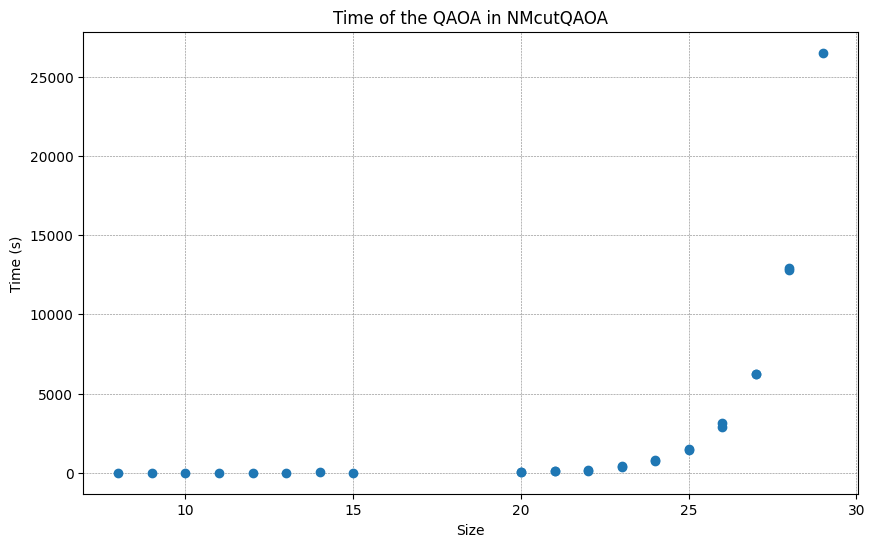

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(qiskit_time['size'], (qiskit_time['time']/1000), 'o', label='NMcutQAOA-Qiskit')
plt.xlabel('Size')
plt.ylabel('Time (s)')
plt.title('Time of the QAOA in NMcutQAOA')
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.show()

Wow, this is a pretty neat exponential function. This makes me wanna try fitting it.

Fitted parameters: a=1.9651893722740862e-05, b=0.724907598723578, c=12.642793112870798
Fitted function: y = 1.965e-05 * exp(0.725 * x) + 12.643
R^2: 0.9999283545591051


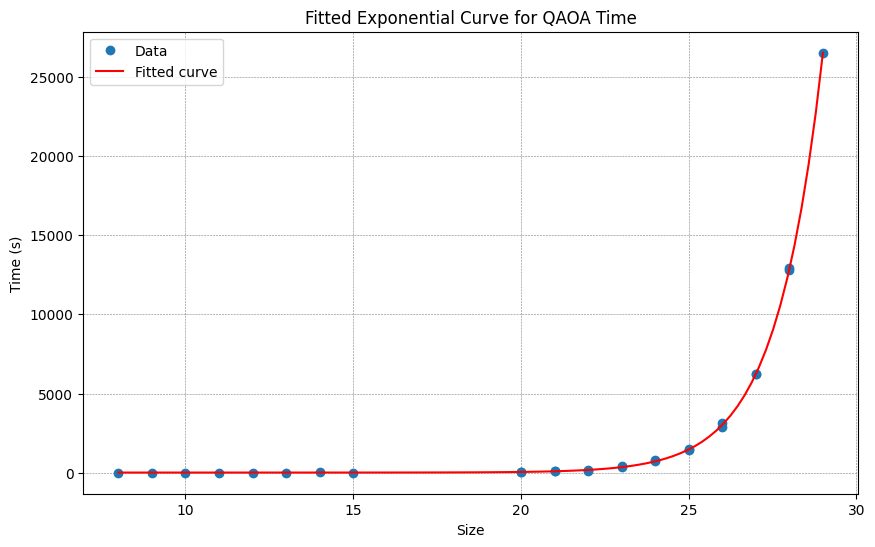

In [66]:
from scipy.optimize import curve_fit

exp = lambda x, a, b, c: a * np.exp(b * x) + c

x1 = np.linspace(8,29,100)
x = qiskit_time['size']
y = qiskit_time['time']/1000

params, cov = curve_fit(exp, x, y)
print(f'Fitted parameters: a={params[0]}, b={params[1]}, c={params[2]}')
print(f'Fitted function: y = {params[0]:.3e} * exp({params[1]:.3f} * x) + {params[2]:.3f}')
print(f'R^2: {1 - np.sum((y - exp(x, *params))**2) / np.sum((y - np.mean(y))**2)}')
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o', label='Data')
plt.plot(x1, exp(x1, *params), label='Fitted curve', color='red')
plt.xlabel('Size')
plt.ylabel('Time (s)')
plt.title('Fitted Exponential Curve for QAOA Time')
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.legend()
plt.show()

As the graph grows exponentially (because the circuit size grows exponentially), let's only graph the time for the values with $size<26$.

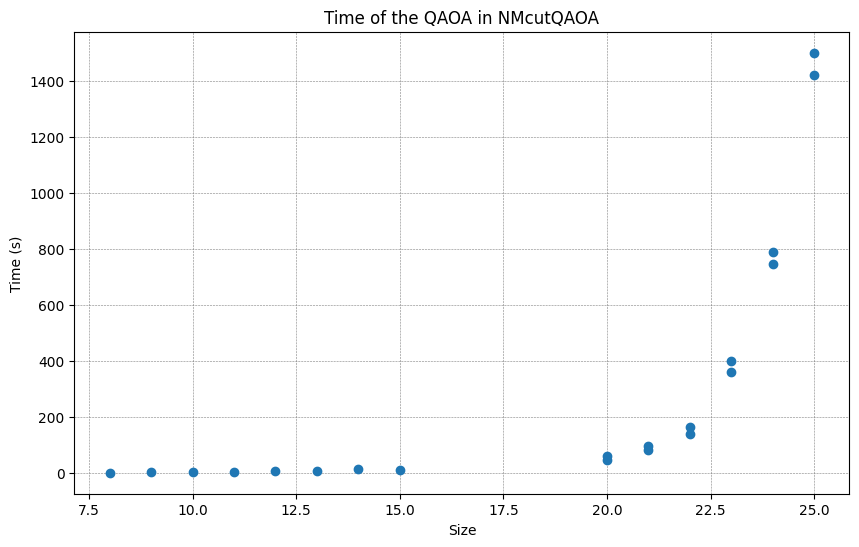

In [64]:
plt.figure(figsize=(10, 6))
filtered_qiskit_time = qiskit_time[qiskit_time['size'] < 26]
plt.plot(filtered_qiskit_time['size'], (filtered_qiskit_time['time']/1000), 'o', label='NMcutQAOA-Qiskit')
plt.xlabel('Size')
plt.ylabel('Time (s)')
plt.title('Time of the QAOA in NMcutQAOA')
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.show()

We still see the same growth pattern. Let's compare (though not useful) the times with the QA approach.

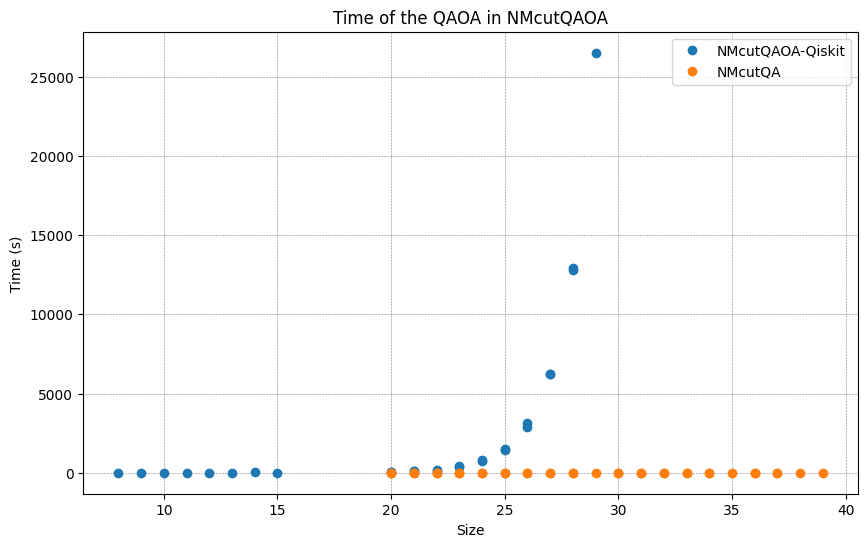

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(qiskit_time['size'], (qiskit_time['time']/1000), 'o', label='NMcutQAOA-Qiskit')
plt.plot(time['size'], (time['time']/1000), 'o', label='NMcutQA')
plt.xlabel('Size')
plt.ylabel('Time (s)')
plt.title('Time of the QAOA in NMcutQAOA')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.show()

As expected, we can see a much better growth, because the growth from the QA is $\mathcal{O}(n\log n)$.

Finally, let's rewrite the graph comparison with NJ, including the QAOA experiments.

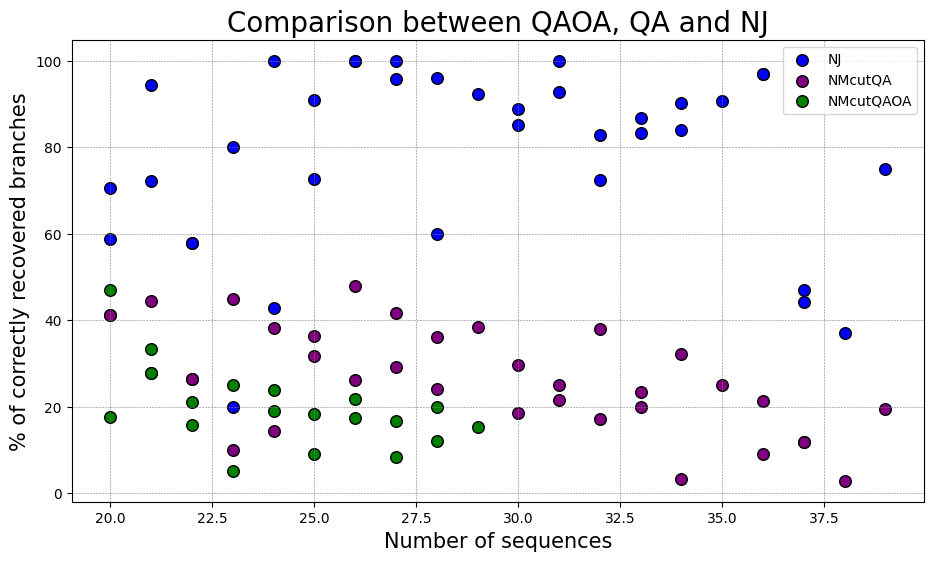

In [76]:
rf_nf = pd.read_csv('metrics/RF-nj.csv')

plt.subplots(figsize=(11, 6))
plt.scatter(rf_nf['size'], rf_nf['RF'], edgecolor='k', color='blue', s=70,label='NJ')
plt.scatter(rf['size'], rf['RF'], edgecolor='k', color='purple', s=70,label='NMcutQA')
plt.scatter(qiskit_df[qiskit_df['size'] >19]['size'], qiskit_df[qiskit_df['size'] >19]['RF'], edgecolor='k', color='green', s=70,label='NMcutQAOA')
plt.xlabel('Number of sequences',fontdict={'fontsize': 15})
plt.ylabel('% of correctly recovered branches',fontdict={'fontsize': 15})
plt.title('Comparison between QAOA, QA and NJ', fontsize=20)
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.legend()
plt.show()